In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
import torchvision.transforms as T
from torchinfo import summary
from torch.optim import Adam

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, match_anchors_to_gt, filter_valid_bboxes, calculate_iou
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors_per_location= 30):
        super(RPN, self).__init__()
        self.num_anchors= num_anchors_per_location
        self.in_channels= in_channels

        self.shared_conv= nn.Conv2d(in_channels, 512, kernel_size= 3, stride= 1, padding= 1)
        self.relu= nn.ReLU(inplace= True)

        self.cls_layer= nn.Conv2d(512, self.num_anchors * 1, kernel_size= 1,
                                  stride= 1, padding= 0)
        
        self.reg_layer= nn.Conv2d(512, self.num_anchors * 4, kernel_size= 1,
                                  stride= 1, padding= 0)
    
    def forward(self, x):
        # Apply shared conv to get features of region proposal
        shared_feats= self.relu(self.shared_conv(x))
        # Get classification scores
        cls_scores= self.cls_layer(shared_feats)
        # Get reg deltas
        reg_deltas= self.reg_layer(shared_feats)

        cls_scores= cls_scores.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        reg_deltas= reg_deltas.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        return {
            'cls_scores': cls_scores,
            'reg_deltas': reg_deltas
        }

In [ ]:
loaded_rpn= RPN(in_channels= 512, num_anchors_per_location= config.NUM_ANCHORS_PER_LOC)
loaded_rpn.load_state_dict(torch.load(config.artifacts_dir + "rpn_3epchs_model_weights.pth"))

<All keys matched successfully>

In [35]:
loaded_rpn_2= torch.load(artifacts_dir + "rpn_3epchs_model.pth")

In [6]:
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha= 0.25, gamma= 2.0):
        super(FocalLoss, self).__init__()
        self.alpha= alpha
        self.gamma= gamma
    def forward(self, logits, targets):
        probs= torch.sigmoid(logits)
        ce_loss= nn.BCEWithLogitsLoss(reduction= 'none')(logits, targets)
        p_t= probs * targets + (1 - probs) * (1 - targets)
        focal_loss= self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean() 

In [ ]:
def rpn_loss_fn(cls_scores, reg_deltas, anchor_labels, regression_targets, device= 'cpu'):
    cls_scores= cls_scores.view(-1)
    anchor_labels= anchor_labels.view(-1)

    # Filtering ignopred anchors (-1)
    valid_mask= anchor_labels >= 0
    cls_scores_valid= cls_scores[valid_mask]
    anchor_labels_valid= anchor_labels[valid_mask]
    anchor_labels_valid= anchor_labels_valid.float().to(device)
    bce_loss= nn.BCEWithLogitsLoss()
    objectness_loss= bce_loss(cls_scores_valid, anchor_labels_valid)

    reg_deltas= reg_deltas.view(-1, 4)
    regression_targets= regression_targets.view(-1, 4)

    positive_mask= anchor_labels == 1
    reg_deltas_positive= reg_deltas[positive_mask]
    regression_targets_positive= regression_targets[positive_mask]
    
    smooth_l1_loss= nn.SmoothL1Loss()
    if reg_deltas_positive.numel() > 0:
        regression_loss= smooth_l1_loss(reg_deltas_positive, regression_targets_positive)
    else:
        regression_loss= torch.tensor(1e-6, device= reg_deltas.device)
    
    lambda_reg= 10.0
    total_loss= objectness_loss + lambda_reg * regression_loss
    return {
        'objectness_loss': objectness_loss,
        'regression_loss': regression_loss,
        'total_loss': total_loss
    }


In [9]:
test_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir,
                          image_list= all_images[:400], max_boxes= 10, transform= transforms)
test_loader= DataLoader(test_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

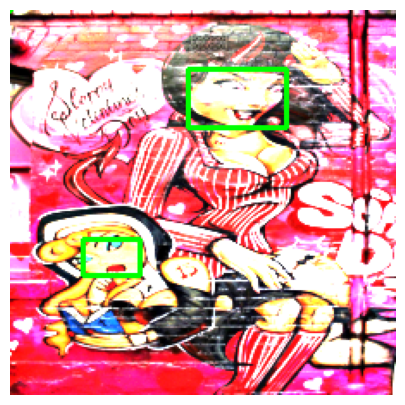

In [10]:
sample_image= test_dataset[2]['image']
sample_label= test_dataset[2]['boxes']
draw_image_with_box(sample_image, sample_label)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_conv_features = torch.load(artifacts_dir + "vgg16_backbone_feat_ext.pth")
vgg16_conv_features.to(device)
loaded_rpn.to(device)
loaded_rpn.eval()

all_precisions = []
all_recalls = []
all_average_precisions = []
loss_history = []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        gt_boxes = batch['boxes'].to(device)

        feature_maps = vgg16_conv_features(images)
        all_anchors = generate_anchor_boxes(
            feature_map_shape=feature_maps.shape[2:4],
            image_shape=images.shape[2:4],
            scales=config.ANCHOR_SCALES,
            ratios=config.ANCHOR_RATIOS,
            stride=config.ANCHOR_STRIDE
        ).to(device)

        rpn_outputs = loaded_rpn(feature_maps.to(device))
        cls_scores = rpn_outputs['cls_scores']
        reg_deltas = rpn_outputs['reg_deltas']

        for i in range(images.size(0)):
            anchor_labels_and_targets = match_anchors_to_gt(
                anchor_boxes=all_anchors,
                gt_boxes=gt_boxes[i],
                iou_high_threshold=config.IOU_HIGH_THRESHOLD,
                iou_low_threshold=config.IOU_LOW_THRESHOLD,
                device=device
            )
            anchor_labels = anchor_labels_and_targets['labels']
            regression_targets = anchor_labels_and_targets['regression_targets']
            cls_probs = torch.sigmoid(cls_scores[i].view(-1))

            # Debugging: Print probabilities
            print(f"Classification probabilities: {cls_probs[:10]}")

            # Adjust threshold for positive anchors
            positive_indices = torch.where(cls_probs > 0.5)[0]
            predicted_boxes = all_anchors[positive_indices]

            # Handle empty ground truth boxes
            if gt_boxes[i].numel() == 0:
                print("No ground truth boxes for this image.")
                continue

            # Compute metrics
            iou_matrix = calculate_iou(predicted_boxes, gt_boxes[i])
            print(f"IOU Matrix: {iou_matrix}")  # Debugging

            true_positives = (iou_matrix.max(dim=1).values > 0.5).sum().item()
            false_positives = len(positive_indices) - true_positives
            false_negatives = gt_boxes[i].size(0) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            all_precisions.append(precision)
            all_recalls.append(recall)
            average_precision = precision * recall
            all_average_precisions.append(average_precision)

            # Compute loss
            losses = rpn_loss_fn(cls_scores[i], reg_deltas[i], anchor_labels, regression_targets, device=device)
            loss_history.append(losses['total_loss'].item())

            print(f"Objectness Loss: {losses['objectness_loss'].item():.4f} | Reg Loss: {losses['regression_loss'].item():.4f}")

    mean_precision = sum(all_precisions) / len(all_precisions)
    mean_recall = sum(all_recalls) / len(all_recalls)
    mean_average_precision = sum(all_average_precisions) / len(all_average_precisions)

    metrics = {
        'precision': mean_precision,
        'recall': mean_recall,
        'mAP': mean_average_precision
    }

    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")
    print(f"Average Loss: {sum(loss_history) / len(loss_history):.4f}")

Classification probabilities: tensor([0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642,
        0.1642], device='cuda:0')
IOU Matrix: tensor([], device='cuda:0', size=(0, 10))
Objectness Loss: 0.1831 | Reg Loss: 0.0093
Classification probabilities: tensor([0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642,
        0.1642], device='cuda:0')
IOU Matrix: tensor([], device='cuda:0', size=(0, 10))
Objectness Loss: 0.1831 | Reg Loss: 0.0329
Classification probabilities: tensor([0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642,
        0.1642], device='cuda:0')
IOU Matrix: tensor([], device='cuda:0', size=(0, 10))
Objectness Loss: 0.1830 | Reg Loss: 0.0475
Classification probabilities: tensor([0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642, 0.1642,
        0.1642], device='cuda:0')
IOU Matrix: tensor([], device='cuda:0', size=(0, 10))
Objectness Loss: 0.1828 | Reg Loss: 0.0614
Classification probabilities: tensor

In [40]:
min(loss_history)

0.23294398188591003

In [41]:
max(loss_history)

3.724008798599243

In [42]:
positives= torch.where(cls_probs > 0.2)
positives[0].shape

torch.Size([0])

In [43]:
torch.sum(anchor_labels==1).item()

3

In [44]:
predicted_boxes

tensor([], device='cuda:0', size=(0, 4))

In [45]:
cls_scores

tensor([[[[[-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269],
           [-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269],
           [-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269],
           ...,
           [-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269],
           [-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269],
           [-1.6269, -1.6269, -1.6269,  ..., -1.6269, -1.6269, -1.6269]]],


         [[[-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818],
           [-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818],
           [-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818],
           ...,
           [-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818],
           [-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818],
           [-1.5818, -1.5818, -1.5818,  ..., -1.5818, -1.5818, -1.5818]]],


         [[[-1.5857, -1.5857, -1.5857,  ..., -1.5857, -1.5857, -1.5857],
           

In [46]:
min(cls_probs[:10])

tensor(0.1642, device='cuda:0')

In [47]:
print(iou_matrix)

tensor([], device='cuda:0', size=(0, 10))


In [48]:
def visualize_predictions(image, predicted_boxes, gt_boxes):
    np_image= image.detach().cpu().numpy()
    np_image= np.transpose(np_image, (1, 2, 0))
    if np_image.max() > 1.0:
        np_image= np_image / 255.0

    np_image= np.clip(np_image, 0.0, 1.0)
    np_image= (np_image * 255).astype(np.uint8)
    image_width, image_height= np_image.shape[:2]

    if not np_image.flags['C_CONTIGUOUS']:
        np_image= np.ascontiguousarray(np_image)
        